In [51]:
import xarray as xr
import sys
sys.path.append("/Users/jkingslake/Documents/science/ApRES/phase-sensitive-radar-processing/code/ApRES_Python_Nicholls_2021")
import ApRESDefs
import importlib
importlib.reload(ApRESDefs) 
import ApRES_plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm
import glob
import gcsfs

In [92]:
class apresarray():
    def __init__(self,dir,remote_load):
        
        # if loading from remote use dir = gs://ldeo-glaciology/GL_apres_2022
        
        
        if remote_load:
            fs = gcsfs.GCSFileSystem()
            dat_filenames = fs.glob(dir + '/**/*.DAT', recursive = True)
        else:
            dat_filenames = glob.glob(dir + '/**/*.DAT',recursive = True)
            
        ## loop through the dat files.
        list_of_multiBurstxarrays = []   
        for dat_filename in iter(dat_filenames[2:3]):
            dat = ApRESDefs.DataFileObject(dat_filename,remote_load)
            
            multiBurstxarray = self._all_bursts_in_dat_to_xarray(dat)
        
            list_of_multiBurstxarrays.append(multiBurstxarray)
            
        self.data = xr.concat(list_of_multiBurstxarrays,dim='time')     
    
    
    def _all_bursts_in_dat_to_xarray(self,dat):
    
    # dat is a ApRESDefs.DataFileObject  
        
        list_of_singleBurst_xarrays = []
        for burst_number in tqdm(range(0,5)):#dat.NoBurstsInFile)):
            burst = dat.ExtractBurst(burst_number)

            singleBurst_xarray = self._burst_to_xarray(burst)

            list_of_singleBurst_xarrays.append(singleBurst_xarray)

        return xr.concat(list_of_singleBurst_xarrays,dim='time') 
    
    def _burst_to_xarray(self,burst):

        chirps , profiles = self._burst_to_3d_arrays(burst,1500)
        chirp_time, profile_range = self._coords_from_burst(burst,1500)
        time = self._timestamp_from_burst(burst)

        chirps = chirps[None,:,:,:]
        profiles = profiles[None,:,:,:]

        xarray_out = xr.Dataset(
            data_vars=dict(
                chirp=(["time","chirp_time", "chirp_num", "attenuator_setting_pair"], chirps),
                profile=(["time", "profile_range", "chirp_num", "attenuator_setting_pair"], profiles),
            ),
            coords=dict(
                time = [time],
                chirp_time=chirp_time,
                profile_range=profile_range, 
                chirp_num = np.arange(burst.Header['NSubBursts']),
                AFGain=(["attenuator_setting_pair"], burst.Header['AFGain'][0:burst.Header['nAttenuators']]),
                attenuator=(["attenuator_setting_pair"], burst.Header['Attenuator1'][0:burst.Header['nAttenuators']]),
            ),
            attrs=dict(description="One burst in an xarray - chirps and profiles"),
        )
        return xarray_out
    
    def _burst_to_3d_arrays(self,burst, max_range=2000):
        burst.Header['N_ADC_SAMPLES']
        chirp_3d = np.zeros((burst.Header['N_ADC_SAMPLES'],burst.Header['NSubBursts'],burst.Header['nAttenuators']))

        test_profile = burst.ExtractChirp([0]).FormProfile()

        profile_3d = np.zeros((len(test_profile.Profile),burst.Header['NSubBursts'],burst.Header['nAttenuators']), dtype=complex)

        setting_counter = 0
        chirp_counter = 0
        for i in np.arange(burst.Header['NChirps']):

            chirp_new = burst.ExtractChirp([i]) 

            profile_new = chirp_new.FormProfile()

            chirp_3d[:,chirp_counter,setting_counter] = chirp_new.vdat
            profile_3d[:,chirp_counter,setting_counter] = profile_new.Profile  

            #print(chirp_counter)

            # keep track of which pair of settings we are using
            setting_counter += 1
            if setting_counter >= burst.Header['nAttenuators']: # if the counter reaches nAttenuators, reset it to zero 
                setting_counter = 0
                chirp_counter += 1


        n = np.argmin(profile_new.Range<=max_range)
        cropped_profile_3d = profile_3d[:n,:,:]    

        return chirp_3d, cropped_profile_3d

    def _coords_from_burst(self, burst, max_range=2000):

        chirp = burst.ExtractChirp([0])

        profile = chirp.FormProfile()
        n = np.argmin(profile.Range<=max_range)
        cropped_range = profile.Range = profile.Range[:n] 
        return  chirp.t, cropped_range

    def _timestamp_from_burst(self,burst):
        return pd.to_datetime(burst.Header["Time stamp"])  
    
    
    def dB(self):
        return 20*np.log10(np.abs(self.data.profile))
    

In [93]:
apresXA = apresarray(dir='gs://ldeo-glaciology/GL_apres_2022',remote_load=True)

100%|█████████████████████████████████████████████| 5/5 [00:19<00:00,  3.92s/it]


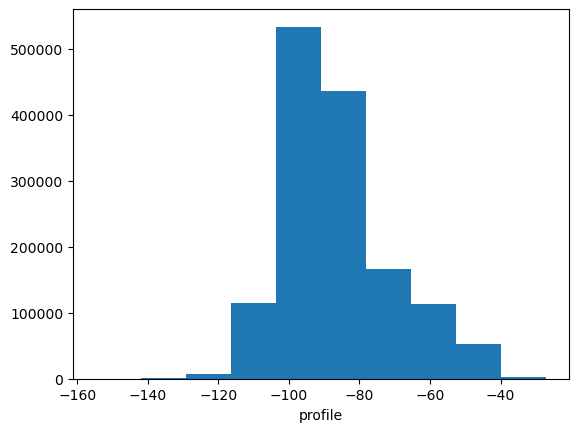

In [97]:
db

<xarray.DataArray 'profile' (time: 5, profile_range: 7134, chirp_num: 20,
                             attenuator_setting_pair: 2)>
array([[[[ -39.61377836,  -39.29648966],
         [ -39.59200432,  -39.29995668],
         [ -39.60015316,  -39.30079157],
         ...,
         [ -39.5722628 ,  -39.27833058],
         [ -39.57351658,  -39.27670415],
         [ -39.5695818 ,  -39.27747491]],

        [[ -40.71600992,  -40.39619628],
         [ -40.6895656 ,  -40.39923382],
         [ -40.69892809,  -40.39962275],
         ...,
         [ -40.66997848,  -40.3768589 ],
         [ -40.67077072,  -40.3749974 ],
         [ -40.66705218,  -40.37599956]],

        [[ -44.13565441,  -43.80689498],
         [ -44.0959556 ,  -43.80912949],
         [ -44.11132639,  -43.80823539],
         ...,
...
         ...,
         [ -87.12330448, -102.32498297],
         [ -85.57727181, -100.22429281],
         [ -85.5038923 , -100.18676265]],

        [[ -93.13727719, -114.46551556],
         [-102.8850325 , -103.63455712],
         [ -92.23430444,  -97.01157888],
         ...,
         [ -88.50689964,  -96.99622861],
         [ -85.54822101, -100.8866103 ],
         [ -85.36407108, -102.85284446]],

        [[ -89.25127065, -106.52686007],
         [-100.14214747, -103.35663861],
         [ -92.83367355,  -95.41361372],
         ...,
         [ -93.69369904,  -94.67171794],
         [ -89.55752648, -101.83053914],
         [ -86.93319687, -109.75442077]]]])
Coordinates:
  * time           (time) datetime64[ns] 2022-05-26T15:37:02 ... 2022-05-26T1...
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.5e+03 1.5e+03
  * chirp_num      (chirp_num) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
    AFGain         (attenuator_setting_pair) int64 -4 -14
    attenuator     (attenuator_setting_pair) float64 5.0 5.0
Dimensions without coordinates: attenuator_setting_pair

In [ ]:
d1 = "DATA2022-05-26-1536.DAT"
d2 = "DATA2022-09-22-2220.DAT"
folder = "/Users/jkingslake/Documents/data/ApRES_greenland/two_examples/"
dat = ApRESDefs.DataFileObject(folder + d1)
apresXA._all_bursts_in_dat_to_xarray(dat)

In [31]:
apresXA.xr

<xarray.Dataset>
Dimensions:        (time: 2, chirp_time: 40001, chirp_num: 20,
                    attenuator_setting_pair: 2, profile_range: 7134)
Coordinates:
  * time           (time) datetime64[ns] 2022-05-26T15:37:02 2022-05-26T15:51:28
  * chirp_time     (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range  (profile_range) float64 0.0 0.2103 0.4206 ... 1.5e+03 1.5e+03
  * chirp_num      (chirp_num) int64 0 1 2 3 4 5 6 7 ... 12 13 14 15 16 17 18 19
    AFGain         (attenuator_setting_pair) int64 -4 -14
    attenuator     (attenuator_setting_pair) float64 5.0 5.0
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp          (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile        (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
Attributes:
    description:  One burst in an xarray - chirps and profiles